In [1]:
# Imported libraries
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score,cross_val_predict, cross_validate
from sklearn.metrics import mean_absolute_error,make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import statsmodels.api as sm

In [2]:
# Read train dataset
sr_df2 = pd.read_csv("C:\\Users\\priya\\OneDrive\\Documents\\final_swr.csv")

In [3]:
# Read POC test dataset
df = pd.read_csv("C:/Users/priya/OneDrive/Documents/age-weight-pocdata/age-weight-poc.csv")

In [4]:
# Dropped Nan values
df.dropna(inplace = True)

In [5]:
# Changed the column names for uniformity
df.columns = ['userId','Weight','Height','Age','Sex']

In [6]:
# Calculated bodysurface variable 
df['BS']= (0.202*(df.Weight**0.425)*((df.Height/100)**0.725)).round(2)
print(df)

    userId  Weight  Height  Age  Sex    BS
0      194   85.00  180.34   36    1  2.05
1      197   96.11  165.10   31    1  2.02
2      198   53.89  160.02   52    0  1.55
3      199   66.67  167.64   29    1  1.75
4      207   90.56  165.10   30    1  1.97
5      209   68.33  177.80   67    1  1.85
6      218  101.00  168.00   28    1  2.09
7      219  115.00  180.00   23    1  2.32
8      220   61.00  172.00   33    1  1.72
9      224   60.00  171.00   27    1  1.70
10     229   96.11  187.96   21    1  2.22
11     230   93.33  187.96   32    1  2.19
12     231   82.22  180.34   46    1  2.02
13     237   50.00  154.00   31    0  1.46
14     238   93.33  172.72   46    1  2.06
15     239  110.00  190.50   52    1  2.38
16     240   82.22  170.18   53    1  1.93
17     247   71.11  167.64   26    1  1.80
18     248   90.56  190.50   26    1  2.19
19     249  107.22  190.50   27    1  2.35
20     250   90.56  185.42   27    1  2.15
21     251   55.56  170.18   40    1  1.64
22     255 

In [7]:
# Calculated the percentage change to know reduction in sweat rate, applied for subjects above age 39 based on age bins.
# Age bins: 40-44, 45-49, 50-55 and 56-70
# Example: If someone inputs age 40-44, we calculate their SWR as if their age was 31 and then reduce this estimate by 5%. 

perChange40_44 = 0.0502
perChange45_49 = 0.0768
perChange50_55 = 0.0882
perChange56_70 = 0.1024

In [8]:
SWR1 = []
# Adjusted sweat rate based on age bins 
for i in range (0,len(df)):
    if (df.Age[i] >= 40 and df.Age[i] <45): 
        age = 31
        Sweat1 = (-10.9045 + 0.05011*age + 13.96646*df.BS[i] - 0.14779*df.Sex[i] + 0.02903*age**2 
             - 0.0005704300166019762*age**3 - 0.84128*age*(df.BS[i]) + 0.01243*(age**2)*(df.BS[i]))
        Sweat = Sweat1 - (perChange40_44*Sweat1) #Sweat rate estimate reduced by 5.02% for age between 40 and 44 with respect to age = 31
    elif (df.Age[i] >= 45 and df.Age[i] <50):
        age = 31
        Sweat1 = (-10.9045 + 0.05011*age + 13.96646*df.BS[i] - 0.14779*df.Sex[i] + 0.02903*age**2 
             - 0.0005704300166019762*age**3 - 0.84128*age*(df.BS[i]) + 0.01243*(age**2)*(df.BS[i]))
        Sweat = Sweat1 - (perChange45_49*Sweat1) #Sweat rate estimate reduced by 7.6% for age between 45 and 49 with respect to age = 31
    elif (df.Age[i] >= 50 and df.Age[i] <56):
        age = 31
        Sweat1 = (-10.9045 + 0.05011*age + 13.96646*df.BS[i] - 0.14779*df.Sex[i] + 0.02903*age**2 
             - 0.0005704300166019762*age**3 - 0.84128*age*(df.BS[i]) + 0.01243*(age**2)*(df.BS[i]))
        Sweat = Sweat1 - (perChange50_55*Sweat1) #Sweat rate estimate reduced by 8.8% for age between 50 and 55 with respect to age = 31
    elif (df.Age[i] >= 56 and df.Age[i] <70):
        age = 31
        Sweat1 = (-10.9045 + 0.05011*age + 13.96646*df.BS[i] - 0.14779*df.Sex[i] + 0.02903*age**2 
             - 0.0005704300166019762*age**3 - 0.84128*age*(df.BS[i]) + 0.01243*(age**2)*(df.BS[i]))
        Sweat = Sweat1 - (perChange56_70*Sweat1) #Sweat rate estimate reduced by 10.2% for age between 56 and 70 with respect to age = 31
    else:
        Sweat = (-10.9045 + 0.05011*df.Age[i] + 13.96646*df.BS[i] - 0.14779*df.Sex[i] + 0.02903*df.Age[i]**2 
             - 0.0005704300166019762*df.Age[i]**3 - 0.84128*df.Age[i]*(df.BS[i]) + 0.01243*(df.Age[i]**2)*(df.BS[i]))
    SWR1.append(Sweat)
    
df['SWR'] = SWR1

In [9]:
# Summary Statistics of POC data
df.SWR.describe() 

count    56.000000
mean      1.054833
std       0.181577
min       0.741520
25%       0.941059
50%       1.002984
75%       1.190793
max       1.498862
Name: SWR, dtype: float64

In [10]:
# Created new dataframe having the estimated Sweat Rate values from the equation which are sorted by age
df1= df[['Age','Weight','Height','BS','Sex','SWR']].sort_values(by='Age')

In [11]:
# Exported POC data to excel file
df1.to_excel("POC2.xlsx") 

In [13]:
# Evaluated accuracy of Sweat rate equation for train data. Created and transferred variables to new dataframe to test equation. 
X_eva = sr_df2[['Age','bodySurface','Sex']]

In [14]:
# Calculated sweat rate from the equation
SWR = []
for i in range (0,len(X_eva)):
    Sweat = -10.9045 + (0.05011*X_eva.Age[i]) + (13.96646*X_eva.bodySurface[i])  + (-0.14779*X_eva.Sex[i]) + (0.02903*(X_eva.Age[i]**2)) + (- 0.84128*X_eva.Age[i]*X_eva.bodySurface[i]) + (- 0.0005704300166019762*(X_eva.Age[i]**3)) + (0.01243*((X_eva.Age[i]**2)*X_eva.bodySurface[i]))
    SWR.append(Sweat)
    
X_eva['Cal_Eq_SWR'] = SWR

In [15]:
# Transferred ground truth sweat rate to new dataframe
X_eva['Actual'] = sr_df2['Sweat_Rate'].values

In [17]:
# Calculated error between calculated and ground truth sweat rate
X_eva['Error1'] = X_eva['Cal_Eq_SWR'] - X_eva['Actual']

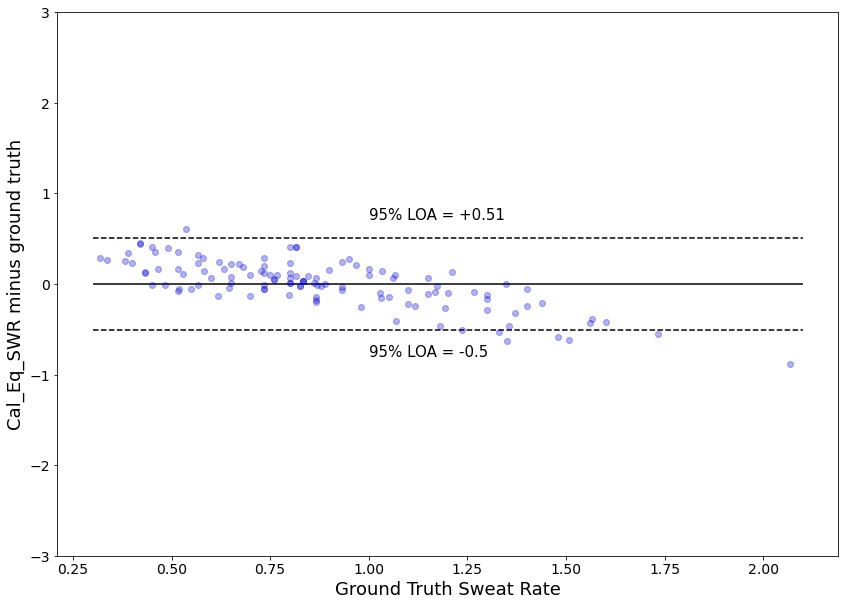

In [18]:
# Bland Altsman Plot for the Error between calculated and ground truth sweat rate
mean_bias = np.nanmean(X_eva['Error1'])
upper_limit = mean_bias + (1.96* (np.std(X_eva['Error1'])))
lower_limit = mean_bias - (1.96* (np.std(X_eva['Error1'])))
plt.figure(figsize=(14,10))
plt.plot(X_eva.Actual, X_eva['Error1'],'o',color='mediumblue',alpha=0.3)
plt.ylim(-3,3)
plt.hlines(y=mean_bias,xmin=np.min(X_eva.Actual.round(1)),xmax=np.max(X_eva.Actual.round(1)),linestyles='solid',color='black')
plt.hlines(y=upper_limit,xmin=np.min(X_eva.Actual.round(1)),xmax=np.max(X_eva.Actual.round(1)),linestyles='dashed',color='black')
plt.hlines(y=lower_limit,xmin=np.min(X_eva.Actual.round(1)),xmax=np.max(X_eva.Actual.round(1)),linestyles='dashed',color='black')

 

plt.ylabel('Cal_Eq_SWR minus ground truth',size=18)
plt.xlabel('Ground Truth Sweat Rate',size=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.annotate('95% LOA = +' + str(round(upper_limit,2)),(1,upper_limit+0.2),size=15)
plt.annotate('95% LOA = ' + str(round(lower_limit,2)),(1,lower_limit-0.3),size=15)
plt.show()
plt.close()

In [24]:
# Checked dta in X_eva dataframe
X_eva[['Age','bodySurface','Sex','Actual','Cal_Eq_SWR','Error1']]

Age  bodySurface  Sex    Actual  Cal_Eq_SWR    Error1
0     21         2.04    1  1.172000    1.153166 -0.018834
1     26         1.77    1  1.235900    0.726644 -0.509256
2     39         2.00    1  1.210000    1.344432  0.134432
3     41         1.66    1  1.000000    1.099267  0.099267
4     21         1.96    1  1.300000    1.010669 -0.289331
..   ...          ...  ...       ...         ...       ...
116   26         1.62    0  0.566667    0.800055  0.233389
117   20         1.56    0  0.450000    0.442321 -0.007679
118   23         2.00    0  0.900000    1.049458  0.149458
119   25         1.62    0  0.733333    0.718231 -0.015102
120   25         1.63    0  0.583333    0.725263  0.141930

[121 rows x 6 columns]

In [22]:
# Checked total number of subjects having underestimated sweat rates
X_eva[X_eva['Error1'] < 0].shape

(57, 6)

In [23]:
# Exported data to excel
X_eva.to_excel("Error1.xlsx") 